# Quantile Linear Regression

Quantile regression models the conditional quantiles of a target variable instead of just the mean (least square method), making it useful for capturing uncertainty in predictions.  

**Key Ideas**  
- Focuses on ranking observations correctly rather than minimizing error.
- Uses a quantile loss function to estimate specific quantiles of the target distribution.  
- Setting ( $\alpha = 0.5$ ) makes the model predict the conditional median of the response variable.  
- Enables the creation of prediction intervals by estimating lower and upper quantiles.  
- Provides a "trust region" where the true value is likely to fall, depending on chosen quantiles.  
- River package: specialize in online training for data stream.

**Model documentation**: https://riverml.xyz/latest/examples/quantile-regression-uncertainty/

**Requirements:**

!pip install river

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.visualization.viz_predictions import plot_dove_predictions
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.datasources.livedata import live_data_generator

from birdgame.visualization.viz_quantile_regression import visualize_quantile_regression
from birdgame.visualization.viz_predictions import plot_dove_predictions
from birdgame.evaluation.normal_dist import compute_score_for_normal_dist
from birdgame.evaluation.utils import find_past_pdf, summarize_predictions

### Warm up example: Quantile regression

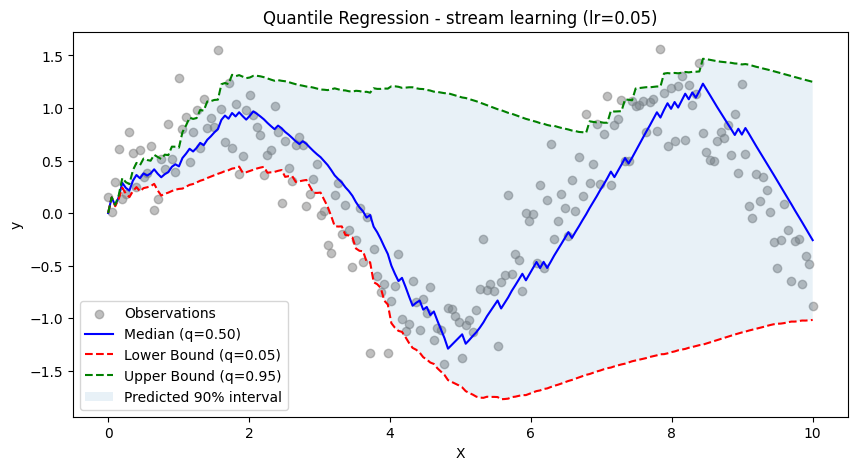

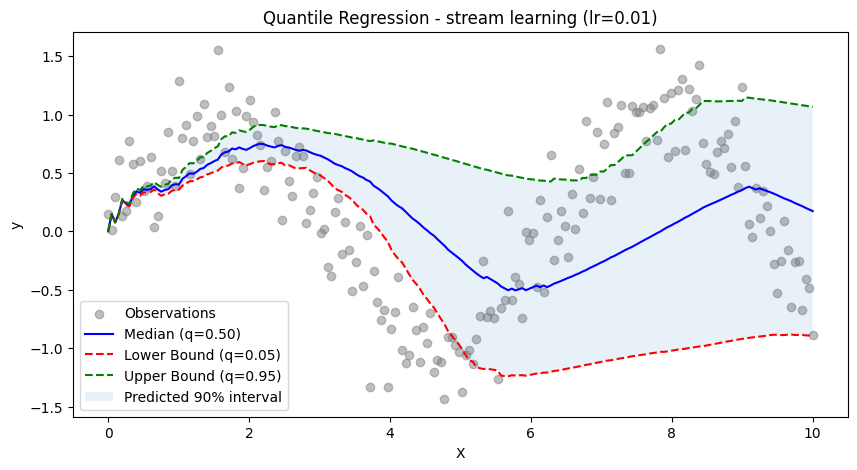

In [2]:
# Run quantile regression for different learning rates
for lr in [0.05, 0.01]:
    visualize_quantile_regression(lr=lr)

In [3]:
from birdgame.trackers.trackerbase import TrackerBase
import numpy as np
from river import linear_model, optim
from river import preprocessing
    

class QuantileRegressionRiverTracker(TrackerBase):
    """
    A model that tracks the dove location using Quantile regression on stream learning.

    Parameters
    ----------
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    """

    def __init__(self, horizon=10):
        super().__init__(horizon)
        self.current_x = None
        self.miss_count = 0

        # Initialize river models dictionary
        self.models = {}
        self.lr = 0.005
        for i, alpha in enumerate([0.05, 0.5, 0.95]):
            scale = preprocessing.StandardScaler()

            # you can optimize learning rate or use other optimizer (RMSProp, ...)
            learn = linear_model.LinearRegression(
                intercept_lr=0,
                optimizer=optim.SGD(self.lr),
                loss=optim.losses.Quantile(alpha=alpha)
            )

            model = scale | learn

            self.models[f"q {alpha:.2f}"] = preprocessing.TargetStandardScaler(regressor=model)

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            ### (optional idea)
            # Get the predicted quantile values from the models
            if "q 0.05" in self.models:
                y_lower = self.models["q 0.05"].predict_one({"x": prev_x})
                y_upper = self.models["q 0.95"].predict_one({"x": prev_x})

                # Check if observed value `x` is between the predicted quantiles
                if y_lower <= x <= y_upper:
                    prediction_error = 0  # prediction is within bounds
                    # idea: learn two time when prediction is within bounds
                    for i, alpha in enumerate([0.05, 0.5, 0.95]):
                        self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)
                else:
                    prediction_error = 1  # prediction is outside bounds
            ###

            # River learn_one (online learning)
            for i, alpha in enumerate([0.05, 0.5, 0.95]):
                self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)

            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution
        modeled as a Gaussian distribution.
        """
        x_mean = self.current_x
        components = []

        if "q 0.05" in self.models:
            # Quantile regression prediction 5%, 50% and 95%
            y_lower = self.models["q 0.05"].predict_one({"x": self.current_x})
            y_mean = self.models["q 0.50"].predict_one({"x": self.current_x})
            y_upper = self.models["q 0.95"].predict_one({"x": self.current_x})

            loc = y_mean
            scale = np.abs((y_upper - y_lower)) / 3.289707253902945    # 3.289707253902945 = (norm.ppf(0.95) - norm.ppf(0.05))
            scale = max(scale, 1e-6)
        else:
            loc = x_mean
            scale = 1.0

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }
        return prediction_density

### Model experimentation

The model is experimented on a data generator using the following metric:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    HORIZON = 10
    MAX_TRACKER_COUNT = 10000
    SHOW_PRINT = True
    STEP_PRINT = 1000
    METRIC = "pdf_score"

# Initialize Tracker
tracker = QuantileRegressionRiverTracker(horizon=Constants.HORIZON)


# History to track evaluation metrics and the PDFs
score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    tracker.tick(payload)
    pdf = tracker.predict()
    current_time = payload['time']

    # Store the latest PDF prediction
    pdf_history.append((current_time, pdf))

    # Find past PDF predicition for evaluation
    past_pdf = find_past_pdf(pdf_history, current_time, Constants.HORIZON)

    if past_pdf:
        observed_dove_location = payload['dove_location']
        weighted_pdf_score, prediction_info = compute_score_for_normal_dist(past_pdf, observed_dove_location, metric=Constants.METRIC)

        # Store results
        score_history.append(weighted_pdf_score)
        prediction_info["time"] = current_time
        store_pred.append(prediction_info)

        if Constants.SHOW_PRINT and len(pdf_history) % Constants.STEP_PRINT == 0:
            print(
                f"[{tracker.count}] {Constants.METRIC}: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                f"pred: {prediction_info["loc"]:.4f} / dif: {observed_dove_location - prediction_info["loc"]:.4f} / "
                f"scale: {prediction_info["scale"]:.4f}"
            )
    else:
        if Constants.SHOW_PRINT:
            print(f"[{tracker.count}] No valid past PDF for evaluation.")

    if tracker.count > Constants.MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[368] pdf_score: 12.9370 / true: 8396.0902 / pred: 8396.1063 / dif: -0.0160 / scale: 0.0252
[726] pdf_score: 36.4800 / true: 8395.4667 / pred: 8395.4720 / dif: -0.0053 / scale: 0.0093
[1061] pdf_score: 0.0000 / true: 8395.8812 / pred: 8395.8778 / dif: 0.0034 / scale: 0.0003
[1449] pdf_score: 9.0240 / true: 8395.0469 / pred: 8395.0572 / dif: -0.0103 / scale: 0.0049
[1819] pdf_score: 62.0400 / true: 8395.6477 / pred: 8395.6447 / dif: 0.0031 / scale: 0.0020
[2213] pdf_score: 0.0000 / true: 8395.7813 / pred: 8395.7468 / dif: 0.0344 / scale: 0.0031
[2553] pdf_score: 735.4930 / true: 8395.7586 / pred: 8395.7583 / dif: 0.0003 / scale: 0.0003
[2929] pdf_score: 20.4520 / true: 8395.0275 / pred: 8395.0273 / dif: 0.0002 / scale: 0.0195
[3319] pdf_score: 0.0000 / true: 8394.8244 / pred: 8394.9851 / dif: -0.1607 / scale: 0.0270
[3640] pdf_score: 15.7880 / true: 8395.1889 / pred: 8395.1991 / dif: -0.0102 / scale: 0.0061
[401

### Prediction summary

In [5]:
skip_length = 500
# Display scores and predictions (skipping first 500 values -> skip warmup of model)
stats_summary, pred_summary = summarize_predictions(score_history, store_pred, skip_length=500)

Median: {'score': 17.813}
Mean: {'score': 30.227}
Std: {'score': 62.476}

Prediction Data:


,loc,scale,dove_location,score,time
0,8396.44422,0.06822,8396.52999,2.65348,102671.0
1,8396.44896,0.06986,8396.51211,3.79515,102672.0
2,8396.44896,0.06986,8396.51211,3.79515,102674.0
3,8396.43648,0.06442,8396.51393,3.00612,102685.0
4,8396.43648,0.06442,8396.52848,2.23375,102686.0
...,...,...,...,...,...
26184,8397.58689,0.00746,8397.58851,52.23096,365278.0
26185,8397.58689,0.00746,8397.58135,40.59629,365279.0
26186,8397.60058,0.00677,8397.58135,1.04063,365285.0
26187,8397.60259,0.00678,8397.58188,0.55365,365288.0


### Visualize predictions

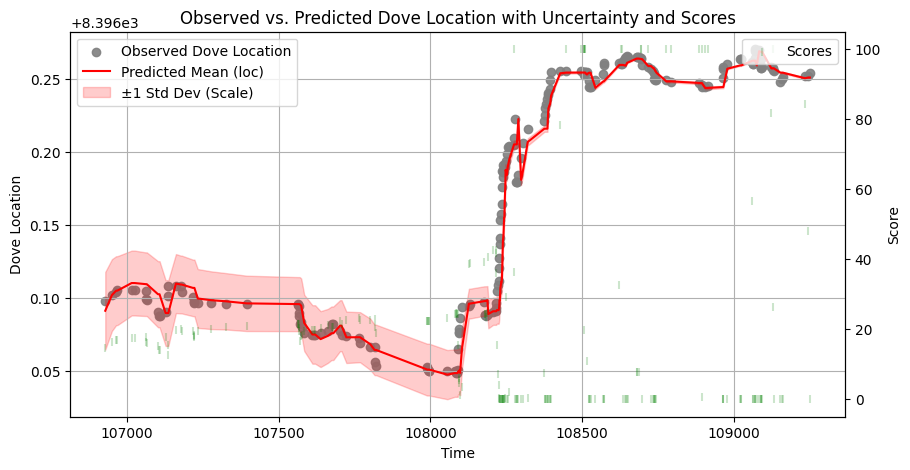

In [6]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

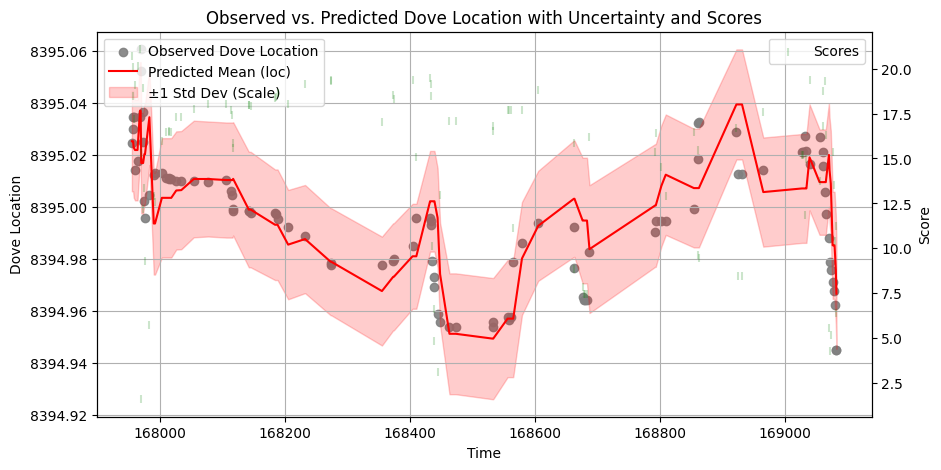

In [7]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)